In [1]:
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
#%env TF_GPU_ALLOCATOR=cuda_malloc_async

env: LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
env: TF_GPU_ALLOCATOR=cuda_malloc_async


In [1]:
import os
print(os.environ["LD_LIBRARY_PATH"])

:/home/nkspartan/miniconda3/envs/tf-gpu/lib/:/home/nkspartan/miniconda3/envs/tf-gpu/lib/


In [16]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt

from keras import Sequential, models, Input
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, GaussianNoise
from keras.optimizers import SGD, Adam

In [17]:
from tensorflow.python.client import device_lib

#print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


2022-10-30 14:54:35.941100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 14:54:35.941344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 14:54:35.941524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 14:54:35.941765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 14:54:35.941951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

## Read the csv dataset to get the values for stage and discharge of the images

In [18]:
df = pd.read_csv("../../dataset/2012_2019_PlatteRiverWeir_features_merged_all.csv")
df.head()

,Unnamed: 0,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df = df[["Filename", "Stage", "Discharge", 'SensorTime']]

In [20]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year

### Remove outliers

In [21]:
df = df[df.Stage > 0]
df = df[df.Discharge > 0]

In [22]:
df.shape

(40148, 5)

### Scale the data

In [23]:
from sklearn.preprocessing import StandardScaler
from joblib import load

scaler = StandardScaler()
#scaler = load('std_scaler.joblib')

In [24]:
df[["Stage", "Discharge"]] = scaler.fit_transform(df[["Stage", "Discharge"]])
df


,Filename,Stage,Discharge,SensorTime,Year
0,StateLineWeir_20120609_Farrell_001.jpg,0.106063,-0.084154,2012-06-09 13:15:00,2012
1,StateLineWeir_20120609_Farrell_002.jpg,0.106063,-0.084154,2012-06-09 13:15:00,2012
2,StateLineWeir_20120609_Farrell_003.jpg,0.069235,-0.119960,2012-06-09 13:45:00,2012
3,StateLineWeir_20120609_Farrell_004.jpg,0.044683,-0.142442,2012-06-09 14:45:00,2012
4,StateLineWeir_20120609_Farrell_005.jpg,0.044683,-0.142442,2012-06-09 15:45:00,2012
...,...,...,...,...,...
42054,StateLineWeir_20191011_Farrell_409.jpg,-0.446354,-0.485510,2019-10-11 09:00:00,2019
42055,StateLineWeir_20191011_Farrell_410.jpg,-0.446354,-0.485510,2019-10-11 10:00:00,2019
42056,StateLineWeir_20191011_Farrell_411.jpg,-0.446354,-0.485510,2019-10-11 11:00:00,2019
42057,StateLineWeir_20191011_Farrell_412.jpg,-0.446354,-0.485510,2019-10-11 12:00:00,2019


In [25]:
from joblib import dump
#dump(scaler, 'std_scaler.joblib')

## Create the dataset pipeline

In [26]:
#IMG_SIZE = 224
IMG_SIZE = 512
BATCH_SIZE = 32

In [33]:
from glob import glob

def make_dataset(path, batch_size, df, seed=None, years=False):
  np.random.seed(seed)

  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

    # image augmentation
    #image = random_image_augmentation(image, 0.7)

    image = tf.cast(image, tf.float32)
    image /= 255
    return image

  def configure_for_performance(ds): 
    if not years:
      pass
      #ds = ds.shuffle(buffer_size=100)  
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

  filenames = glob(path + '/*')
  train_files = []
  val_files = []
  test_files = []
  
  if years:
    """files = set(df[(df.Year >= 2012) & (df.Year <= 2016)].Filename.values)
    train_files = [file for file in filenames if file.split('/')[-1] in files]
    print("\n".join(train_files))
    print("hell")
    print(len(train_files))
    files = set(df[(df.Year >= 2017) & (df.Year <= 2017)].Filename.values)
    val_files = [file for file in filenames if file.split('/')[-1] in files]
    print("\n".join(val_files))
    print("hell")
    print(len(val_files))

    files = set(df[(df.Year >= 2018) & (df.Year <= 2019)].Filename.values)
    test_files = [file for file in filenames if file.split('/')[-1] in files]
    print(len(test_files))"""
    files = df[(df.Year >= 2012) & (df.Year <= 2016)].Filename.values
    train_files = [os.path.join(path, file) for file in files]

    files = df[(df.Year >= 2017) & (df.Year <= 2017)].Filename.values
    val_files = [os.path.join(path, file) for file in files]

    files = df[(df.Year >= 2018) & (df.Year <= 2019)].Filename.values
    test_files = [os.path.join(path, file) for file in files]

    # if the data is passed in order, the model just can't understand the problem so we use shuffle. Maybe because the model just can't go down the gradient because it gets confused, because the data being passed goes up then down then up then down, so it doesn't know what to do
    np.random.shuffle(train_files)
    np.random.shuffle(val_files)
    np.random.shuffle(val_files)

    print(len(train_files))
    print(len(val_files))
    print(len(test_files))
  else:
    # make train, val and test splits of the dataset (70%, 10%, 20% split)
    split1 = int(0.7 * len(filenames))
    split2 = int(0.8 * len(filenames))

    np.random.shuffle(filenames)
    train_files = filenames[:split1] # up to split 1 (ex 70%)
    val_files = filenames[split1:split2] # from ex. 70% to 80%
    test_files = filenames[split2:] # from ex. 80% until the end

  # create stage values
  stage_train_values = [df[df.Filename == file.split('/')[-1]].Stage.values for file in train_files]
  stage_val_values = [df[df.Filename == file.split('/')[-1]].Stage.values for file in val_files]
  stage_test_values = [df[df.Filename == file.split('/')[-1]].Stage.values for file in test_files]

  # create discharge values
  discharge_train_values = [df[df.Filename == file.split(
      '/')[-1]].Discharge.values for file in train_files]
  discharge_val_values = [df[df.Filename == file.split(
      '/')[-1]].Discharge.values for file in val_files]
  discharge_test_values = [df[df.Filename == file.split(
      '/')[-1]].Discharge.values for file in test_files]

  # join stage and discharge values
  stage_discharge_train_values = [[np.squeeze(s), np.squeeze(d)] for s, d in zip(stage_train_values, discharge_train_values)]
  stage_discharge_val_values = [[np.squeeze(s), np.squeeze(d)] for s, d in zip(stage_val_values, discharge_val_values)]
  stage_discharge_test_values = [[np.squeeze(s), np.squeeze(
      d)] for s, d in zip(stage_test_values, discharge_test_values)]

  # create images dataset (train, val, test)
  filenames_train_ds = tf.data.Dataset.from_tensor_slices(train_files)
  filenames_val_ds = tf.data.Dataset.from_tensor_slices(val_files)
  filenames_test_ds = tf.data.Dataset.from_tensor_slices(test_files)

  images_train_ds = filenames_train_ds.map(parse_image, num_parallel_calls=8)
  images_val_ds = filenames_val_ds.map(parse_image, num_parallel_calls=8)
  images_test_ds = filenames_test_ds.map(parse_image, num_parallel_calls=8)

  # create stage and discharge dataset (train, val, test)
  stage_discharge_train_ds = tf.data.Dataset.from_tensor_slices(stage_discharge_train_values)
  stage_discharge_val_ds = tf.data.Dataset.from_tensor_slices(stage_discharge_val_values)
  stage_discharge_test_ds = tf.data.Dataset.from_tensor_slices(
      stage_discharge_test_values)

  # create tensorflow dataset of images and values (train, val, test)
  train_ds = tf.data.Dataset.zip((images_train_ds, stage_discharge_train_ds))
  train_ds = configure_for_performance(train_ds)
  val_ds = tf.data.Dataset.zip((images_val_ds, stage_discharge_val_ds))
  val_ds = configure_for_performance(val_ds)
  test_ds = tf.data.Dataset.zip((images_test_ds, stage_discharge_test_ds))
  test_ds = configure_for_performance(test_ds)

  return train_ds, len(train_files), val_ds, len(val_files), test_ds, len(test_files)

In [34]:
path = "../../dataset/images_tmp_draw"

train_ds, train_size, val_ds, val_size, test_ds, test_size = make_dataset(path, BATCH_SIZE, df, 10, True)

2022-10-30 15:01:46.473582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 15:01:46.473783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 15:01:46.473924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 15:01:46.474256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 15:01:46.474432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [35]:
input_shape = 0
output_shape = 0

for image, stage_discharge in train_ds.take(1):
    print(image.numpy().shape)
    print(stage_discharge.numpy().shape)

    input_shape = image.numpy().shape[1:]
    output_shape = stage_discharge.numpy().shape[1:]

(32, 512, 512, 3)
(32, 2)


In [36]:
print(input_shape)
print(output_shape)

(512, 512, 3)
(2,)


## Check images

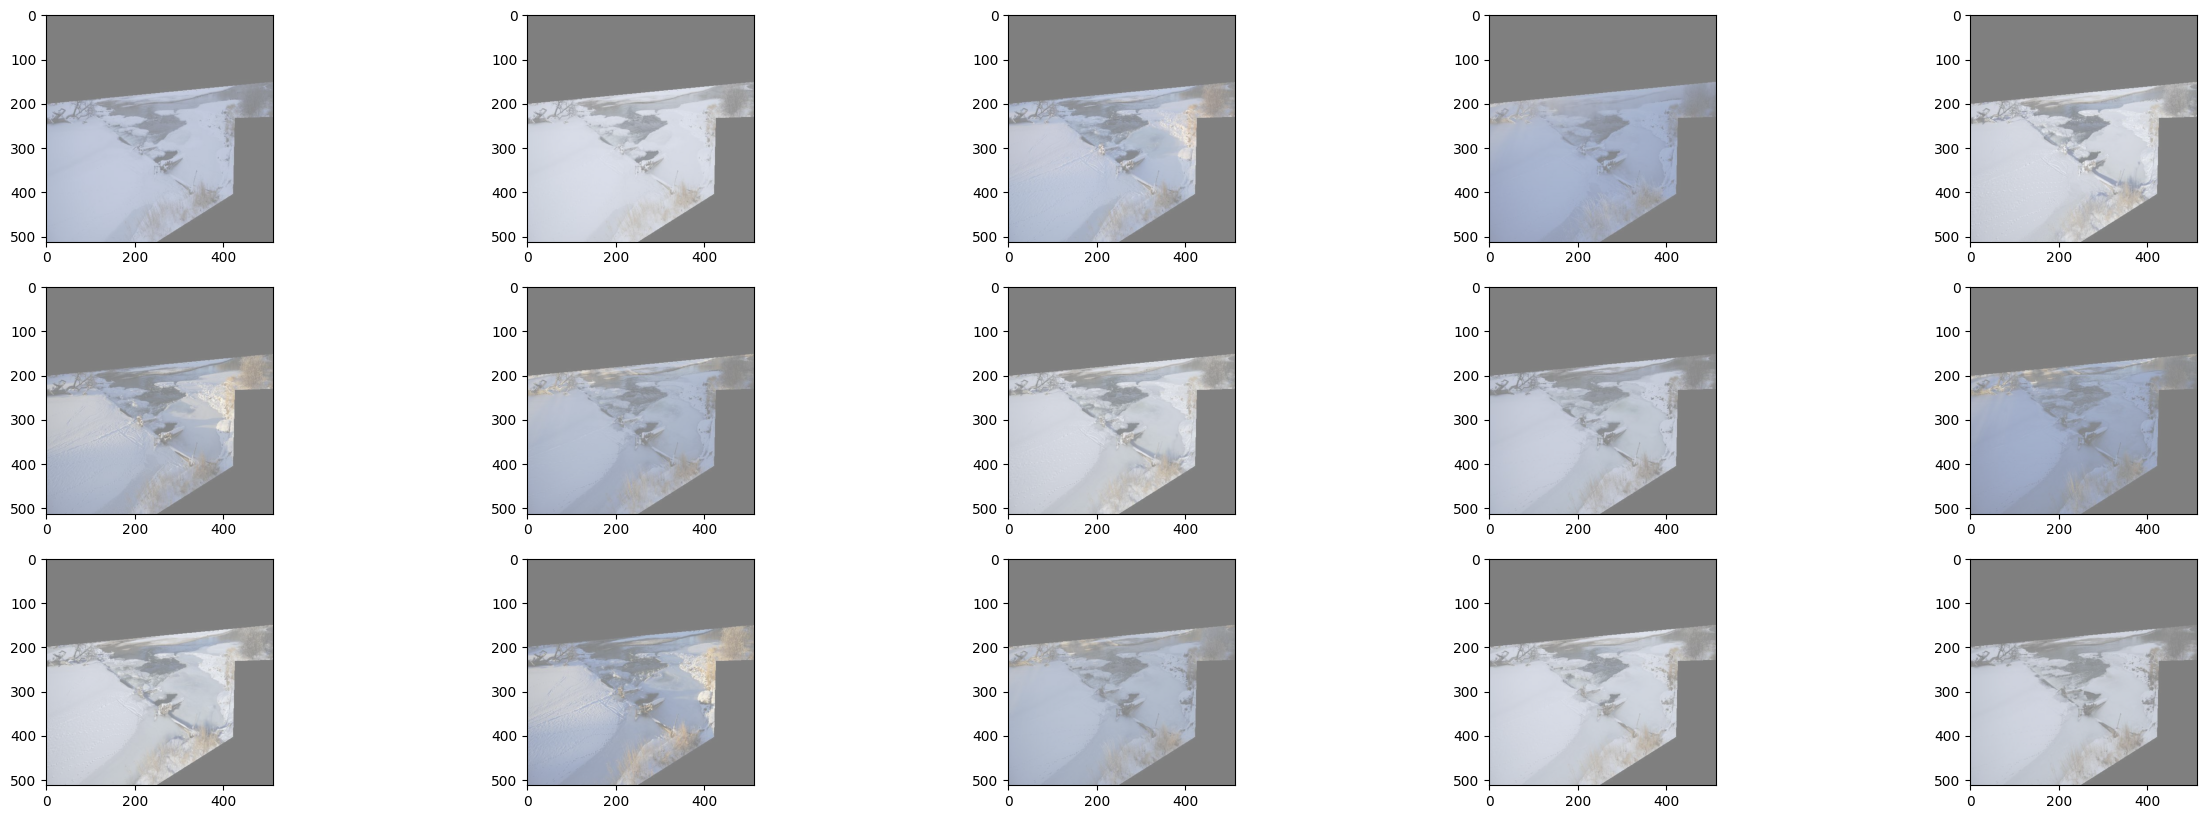

In [37]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(30, 10))

for image, stage_discharge in test_ds.take(1):
    images = image[:15]
    for img, ax in zip(images, ax.flatten()):
        img = img.numpy()
        img = img / 2 + 0.5     # unnormalize
        ax.imshow(img)

plt.show()

## Create model

In [62]:
def create_model(input_shape, output_shape, transfer_learning=False):
    model = Sequential()

    if (transfer_learning == True):
        base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                                weights='imagenet',
                                                input_shape=input_shape)
        base_model.trainable = False
        base_model._name = 'base_model_MobileNet'

        model.add(base_model)
        model.add(Dropout(0.6))
        model.add(GlobalAveragePooling2D())

        model.add(Dense(512, activation='tanh'))
        model.add(Dense(256, activation='tanh'))
        model.add(Dense(256, activation='tanh'))
        model.add(Dense(64, activation='tanh'))
    else:
        model.add(Input(shape=input_shape))

        model.add(Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', activation=LeakyReLU()))
        model.add(MaxPooling2D(pool_size=(4, 4)))

        model.add(Conv2D(64, kernel_size=(4, 4), strides=(2, 2), activation=LeakyReLU(), padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, kernel_size=(3, 3), activation=LeakyReLU(0.2), padding='same'))
        #model.add(AveragePooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))

        model.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
        model.add(AveragePooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(128, activation='tanh'))
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='tanh'))
        model.add(Dense(32, activation='tanh'))
        model.add(Dense(32, activation='tanh'))
        
    model.add(Dense(output_shape, activation='linear')) # linear regression output layer

    return model


In [63]:
model = create_model(input_shape, output_shape[0], False)

In [64]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 256, 256, 64)      3136      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        65600     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 32)        18464     
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 32)       

In [65]:
def compile_model(loss_func, optimizer, metrics=["accuracy"]):
    model.compile(loss=loss_func, optimizer=optimizer, metrics=metrics)

In [66]:
sgd = SGD(learning_rate=0.01, decay=1e-4, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=1e-3, decay=1e-3 / 200)

compile_model('mse', adam,  [
              'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])


In [67]:
def fit_model(training_values, validation_values=None, epochs=10, steps=32, val_steps=32, callbacks=[]):
    return model.fit(training_values, validation_data=validation_values, epochs=epochs, steps_per_epoch=steps, validation_steps=val_steps, callbacks=callbacks)

In [68]:
import datetime

date_actual = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/cnn_v2_orig_logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_weights/cnn_v2_orig.hdf5",
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True)


In [69]:
# batch_size = 0 because we already have batch size in tf dataset
model_h = fit_model(train_ds, val_ds, epochs=15, steps=np.ceil(train_size / BATCH_SIZE), val_steps=np.ceil(val_size / BATCH_SIZE), callbacks=[tensorboard_callback, es_callback, checkpoint_callback])

Epoch 1/15
634/635 [============================>.] - ETA: 0s - loss: 0.1441 - mse: 0.1441 - rmse: 0.3796 - mae: 0.2078 - mape: 79.4903
Epoch 1: val_loss improved from inf to 0.03896, saving model to model_weights/cnn_v2_orig.hdf5
635/635 [==============================] - 72s 113ms/step - loss: 0.1440 - mse: 0.1440 - rmse: 0.3795 - mae: 0.2077 - mape: 79.4387 - val_loss: 0.0390 - val_mse: 0.0390 - val_rmse: 0.1974 - val_mae: 0.1347 - val_mape: 34.9823
Epoch 2/15
635/635 [==============================] - ETA: 0s - loss: 0.0200 - mse: 0.0200 - rmse: 0.1415 - mae: 0.0941 - mape: 43.0462
Epoch 2: val_loss improved from 0.03896 to 0.02794, saving model to model_weights/cnn_v2_orig.hdf5
635/635 [==============================] - 71s 112ms/step - loss: 0.0200 - mse: 0.0200 - rmse: 0.1415 - mae: 0.0941 - mape: 43.0462 - val_loss: 0.0279 - val_mse: 0.0279 - val_rmse: 0.1672 - val_mae: 0.1165 - val_mape: 31.7716
Epoch 3/15
634/635 [============================>.] - ETA: 0s - loss: 0.0139 - mse

## Evaluate model

In [70]:
print(date_actual)

20221030-151555


In [71]:
best_model = models.load_model(f'model_weights/cnn_v2_orig.hdf5')

In [72]:
def evaluate_model(model, test_values, steps):
  score = model.evaluate(test_values, steps=steps)
  return score

In [73]:
test_loss, test_mse, test_rmse, test_mae, test_mape = evaluate_model(best_model, test_ds, steps=np.ceil(test_size / BATCH_SIZE))

398/398 [==============================] - 24s 60ms/step - loss: 0.0316 - mse: 0.0316 - rmse: 0.1779 - mae: 0.1226 - mape: 59.9863


In [74]:
for image, stage_discharge in test_ds.take(1):
	predictions = best_model.predict(x=image)

	stage_discharge_test_values = stage_discharge[:2].numpy()
	predictions_values = predictions[:2]
	
	diff = predictions_values.flatten() - stage_discharge_test_values.flatten()
	percentDiff = (diff / stage_discharge_test_values.flatten()) * 100
	absPercentDiff = np.abs(percentDiff)
	# compute the mean and standard deviation of the absolute percentage
	# difference
	mean = np.mean(absPercentDiff)
	std = np.std(absPercentDiff)
	# finally, show some statistics on our model
	print(mean)
	print(std)

	stage_discharge_test_values = stage_discharge[:10]
	predictions_values = predictions[:10]

	for i in range(len(stage_discharge_test_values.numpy())):
		print(f"pred stage: {scaler.inverse_transform(predictions_values)[i][0]}, actual stage: {scaler.inverse_transform(stage_discharge_test_values)[i][0]}")
		print(f"pred discharge: {scaler.inverse_transform(predictions_values)[i][1]}, actual discharge: {scaler.inverse_transform(stage_discharge_test_values)[i][1]}")

1/1 [==============================] - 0s 132ms/step
32.48392921369489
14.056445422486094
pred stage: 2.587742567062378, actual stage: 2.31
pred discharge: 564.3262329101562, actual discharge: 210.0
pred stage: 2.4679222106933594, actual stage: 2.41
pred discharge: 432.01129150390625, actual discharge: 210.0
pred stage: 2.2320761680603027, actual stage: 2.67
pred discharge: 219.2568359375, actual discharge: 210.0
pred stage: 2.460573434829712, actual stage: 2.43
pred discharge: 534.532470703125, actual discharge: 210.0
pred stage: 2.2819080352783203, actual stage: 2.42
pred discharge: 234.22296142578125, actual discharge: 210.0
pred stage: 2.199291229248047, actual stage: 2.71
pred discharge: 202.26739501953125, actual discharge: 210.0
pred stage: 2.2586727142333984, actual stage: 2.71
pred discharge: 221.744873046875, actual discharge: 210.0
pred stage: 2.250209331512451, actual stage: 2.76
pred discharge: 215.526611328125, actual discharge: 210.0
pred stage: 2.3038315773010254, actua

### Residual analysis

In [ ]:
y_predictions = np.empty(shape=(1, 2))
y_real = np.empty(shape=(1, 2))

"""for image, stage_discharge in test_ds.take(100):
    y_predictions = np.concatenate((y_predictions, best_model.predict(x=image)))
    y_real = np.concatenate((y_real, stage_discharge.numpy()))"""

/tmp/ipykernel_92918/3264406076.py:11: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")


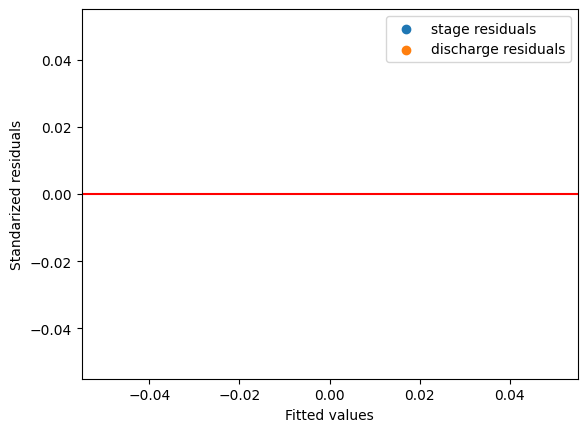

In [ ]:
residuals = y_real - y_predictions
residuals_std = residuals/residuals.std()

y_real_stage = np.array([i[0] for i in y_real])
residual_stage = np.array([i[0] for i in residuals])

y_real_discharge = np.array([i[1] for i in y_real])
residual_discharge = np.array([i[1] for i in residuals])

plt.scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
plt.scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.xlabel("Fitted values")
plt.ylabel("Standarized residuals")

plt.legend()
plt.show()

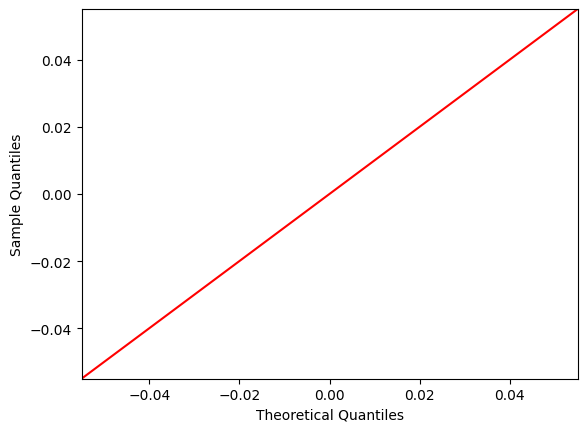

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad

figure = sm.qqplot(residual_stage / residual_stage.std(), line ='45', label='stage')
plt.show()

/tmp/ipykernel_92918/1192211388.py:1: RuntimeWarning: divide by zero encountered in divide
  figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')


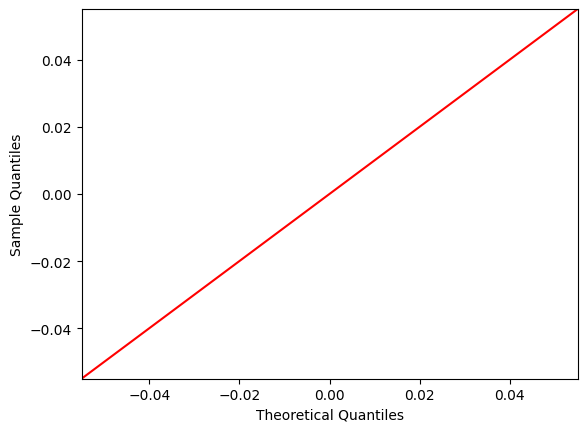

In [ ]:
figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')
plt.show()

In [ ]:
import seaborn as sns

#sns.histplot(residuals, kde=True, bins = 10)

In [ ]:
stat, pval = normal_ad(residual_stage)
print("p-value:", pval)

if pval<0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")

p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
stat, pval = normal_ad(residual_discharge)
print("p-value:", pval)

if pval < 0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")


p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Visualize layers

In [ ]:
layer_outputs = [layer.output for layer in best_model.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=best_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
activations = activation_model.predict(test_ds.take(1)) 

1/1 [==============================] - 0s 143ms/step


2022-10-30 15:31:48.521823: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.


conv2d_15
max_pooling2d_6
conv2d_16
max_pooling2d_7
conv2d_17
conv2d_18
conv2d_19
average_pooling2d_3
flatten_3


/tmp/ipykernel_92918/1031377702.py:24: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


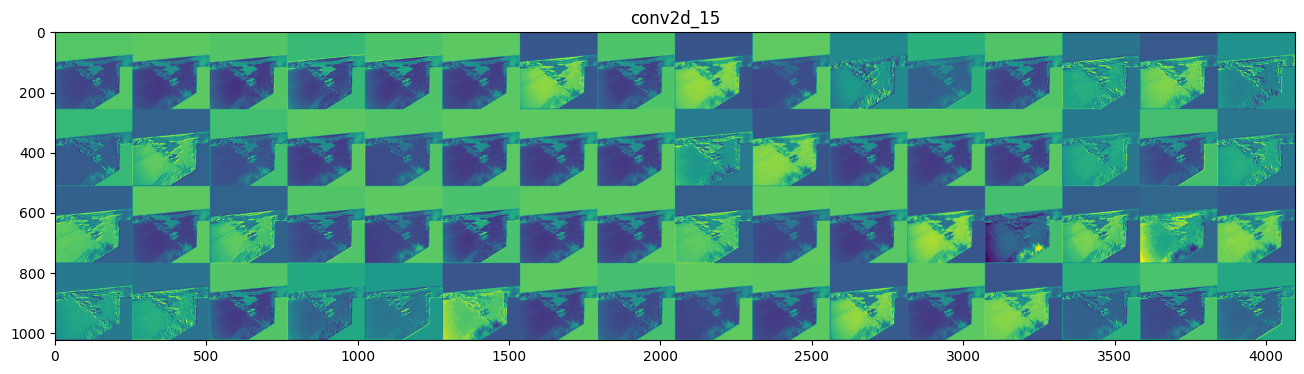

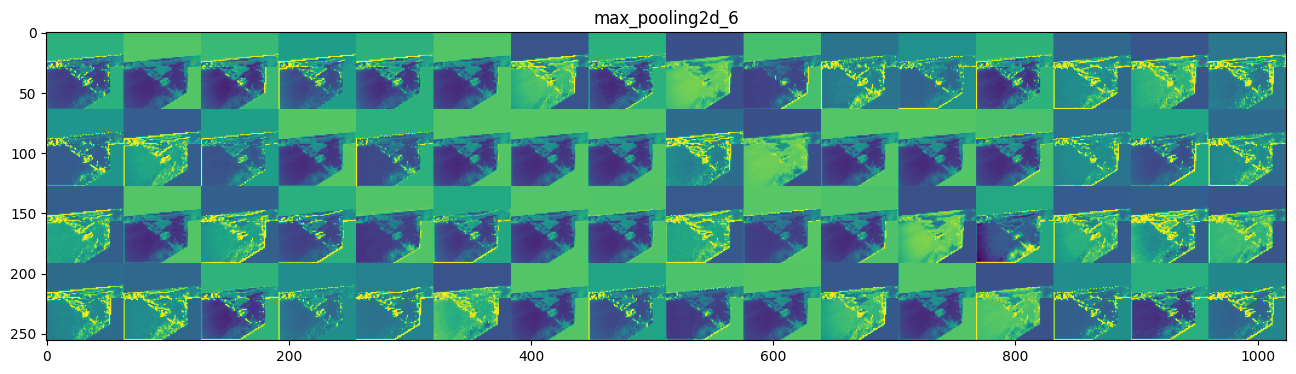

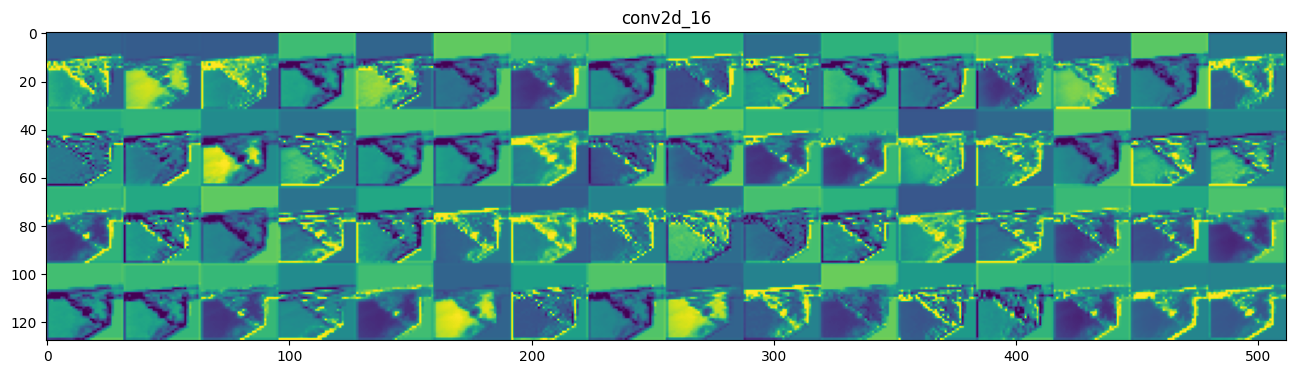

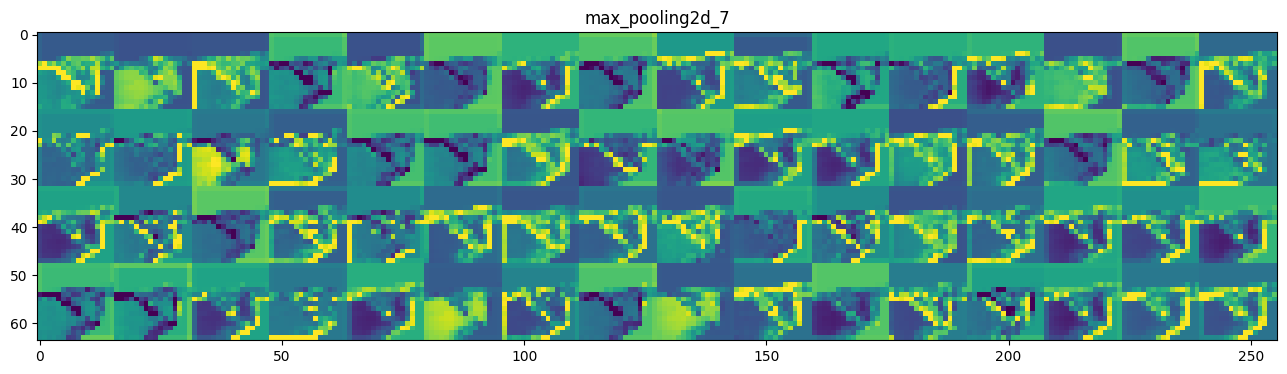

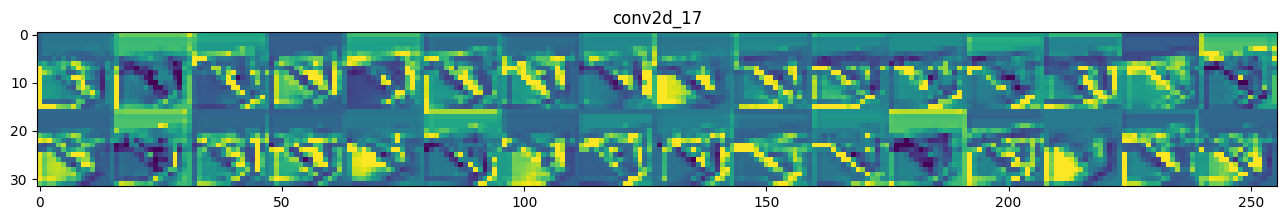

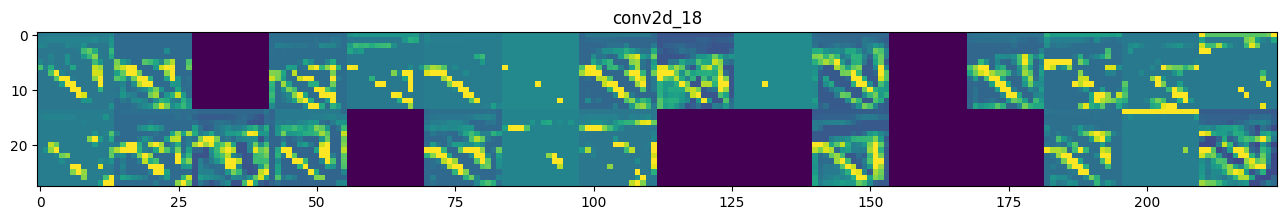

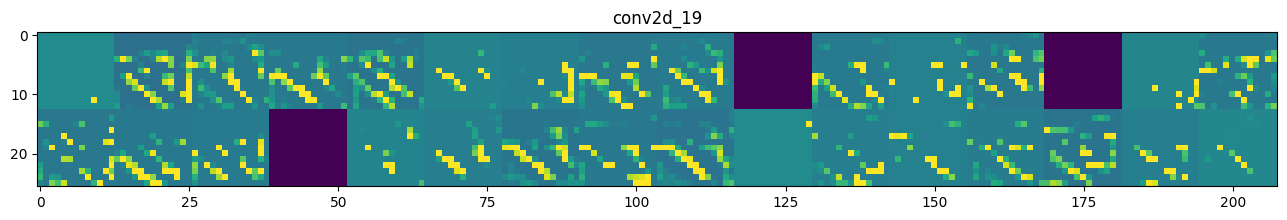

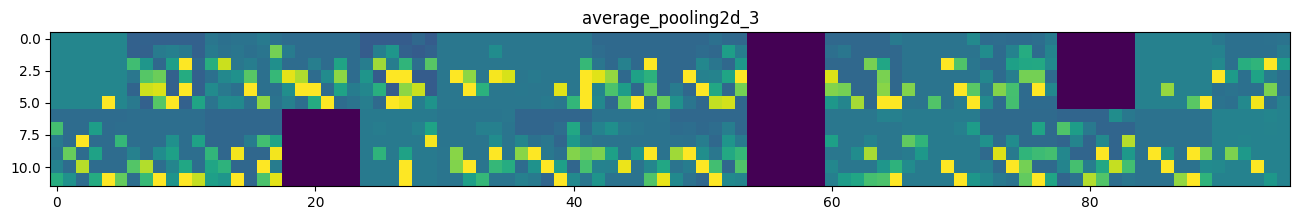

In [ ]:
import matplotlib.pyplot as plt

layer_names = []
for layer in best_model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    print(layer_name)
    if "flatten" in layer_name or "dense" in layer_name: break

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')